# Bachelor End Project (BEP) - Els Brouwer - June 2025

## Set up

In [14]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import mode
from tqdm import tqdm  # progress bar
from collections import Counter

Check sklearn version for default values used

In [15]:
import sklearn
print(sklearn.__version__)

1.6.1


# 1. Linear Data

## 1.1 Generating Linear High Dimensional Data Sets

The following function generates linear data in the following way:
The number of observations n and number of features p are chosen.
Create feature matrix X, size n x p. Create true weights theta, size p x 1. There are as many non-zero elements in the true weights as there are informative features.
Generate label y with X @ theta + epsilon. Epsilon is Gaussian noise with an amplitude variable. 

In [16]:
def generate_linear_data_theta(n_observations, n_informative, informative_ratio, noise_amplitude, random_seed):
    # random seed for reproducibility
    np.random.seed(random_seed)

    # Compute total number of features from the ratio
    n_features = int(n_informative / informative_ratio)
    
    # Generate random feature matrix
    X = np.random.randn(n_observations, n_features)

    # True weights
    true_weights = np.zeros(n_features)
    true_weights[:n_informative] = [1,-2,3,-4,5]

    # Linear combination + noise
    y = X @ true_weights + noise_amplitude * np.random.randn(n_observations)

    return X, y, n_features

## 1.2 Penalized Regression with Ridge (Linear)

#### 1.2.1 Dataframe with all results Ridge created

In [17]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# alpha_grid = {'ridge__alpha': np.logspace(-4, 4, 30)}
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1]
# n_informative = 5 # Always 5 informative features

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         alpha_list = []
#         selected_features_list = []
#         grid_time_list = []
#         model_coef_list = []
#         correct_selected_features_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = []  

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_linear_data_theta(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model pipeline with StandardScaler, Ridge and gridSearchCV
#             ridge_pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 ('ridge', Ridge(random_state=42))
#             ])

#             grid_search = GridSearchCV(
#                 ridge_pipeline,
#                 param_grid=alpha_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             coef = best_model.named_steps['ridge'].coef_
#             model_coef_list.append(coef)

#             # Best parameter
#             best_alpha = grid_search.best_params_['ridge__alpha']
#             alpha_list.append(best_alpha)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature selection
#             threshold = 1e-3
#             n_selected = np.sum(np.abs(coef) > threshold)
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(np.abs(coef[:n_informative]) > threshold)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute coefficient magnitude and index
#             coef_magnitudes = np.abs(coef)
#             top_5_indices = np.argsort(coef_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(coef_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of the simulations
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'features_informative': n_informative,
#                 'features_noninformative': n_features - n_informative,
#                 'simulation': sim,
#                 'mse': mse,
#                 'alpha': best_alpha,
#                 'selected_features': n_selected,
#                 'grid time': grid_time,
#                 'model_coef': coef.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })

#         # Save mean results
#         all_results.append({
#             'noise': noise_amplitude,
#             'ir': informative_ratio,
#             'features': n_features,
#             'mean_mse': np.mean(mse_list),
#             'std_mse': np.std(mse_list),
#             'modus_alpha': mode(alpha_list, keepdims=True).mode[0],
#             'mean_selected_total': np.mean(selected_features_list),
#             'std_selected_total': np.std(selected_features_list),
#             'mean_correct_selected': np.mean(correct_selected_features_list),
#             'std_correct_selected': np.std(correct_selected_features_list),
#             'mean_grid_time': np.mean(grid_time_list),
#             'std_grid_time': np.std(grid_time_list),
#             'mean_precision': np.mean(precision_list),
#             'std_precision': np.std(precision_list),
#             'mean_recall': np.mean(recall_list),
#             'std_recall': np.std(recall_list),
#             'p/n': n_features / n_observations_train,
#             'mean_precision5': np.mean(precision5_list),
#             'std_precision5': np.std(precision5_list),
#             'mean_precision10': np.mean(precision10_list),
#             'std_precision10': np.std(precision10_list),
#         })

# # === Save results to CSV ===
# df_Ridge = pd.DataFrame(all_results)
# df_Ridge.to_csv('df_Ridge_high_dim_linear_all_results_theta.csv', index=False)
# print("DataFrame Ridge has been saved as CSV file.")

# df_Ridge_simulations = pd.DataFrame(all_simulation_results)
# df_Ridge_simulations.to_csv('df_Ridge_high_dim_linear_simulations_theta.csv', index=False)
# print("Saved detailed Ridge simulation results to 'df_Ridge_high_dim_linear_simulations_theta.csv'")


## 1.3 Penalized Regression with Lasso (Linear)

#### 1.3.1 Dataframe Lasso: Vary noise amplitude, ratio informative and dataset size for linear data

In [18]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# alpha_grid = {'lasso__alpha': np.logspace(-4, 4, 30)}
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1]
# n_informative = 5 # Always 5 informative features

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         alpha_list = []
#         selected_features_list = []
#         grid_time_list = []
#         model_coef_list = []
#         correct_selected_features_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = [] 

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_linear_data_theta(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model pipeline with StandardScaler, Lasso and gridSearchCV
#             lasso_pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 ('lasso', Lasso(max_iter=10000, random_state=42))
#             ])

#             grid_search = GridSearchCV(
#                 lasso_pipeline,
#                 param_grid=alpha_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             coef = best_model.named_steps['lasso'].coef_
#             model_coef_list.append(coef)

#             # Best parameter
#             best_alpha = grid_search.best_params_['lasso__alpha']
#             alpha_list.append(best_alpha)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature selection
#             # Lasso automatically sets coefficients to zero, no need for a threshold
#             n_selected = np.sum(coef != 0)  
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(coef[:n_informative] != 0)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute coefficient magnitude and index
#             coef_magnitudes = np.abs(coef)
#             top_5_indices = np.argsort(coef_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(coef_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of this simulation
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'features_informative': n_informative,
#                 'features_noninformative': n_features - n_informative,
#                 'simulation': sim,
#                 'mse': mse,
#                 'alpha': best_alpha,
#                 'selected_features': n_selected,
#                 'grid time': grid_time,
#                 'model_coef': coef.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })

#         # Save mean results
#         all_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'mean_mse': np.mean(mse_list),
#                 'std_mse': np.std(mse_list),
#                 'modus_alpha': mode(alpha_list, keepdims=True).mode[0],
#                 'mean_selected_total': np.mean(selected_features_list),
#                 'std_selected_total': np.std(selected_features_list),
#                 'mean_correct_selected': np.mean(correct_selected_features_list),
#                 'std_correct_selected': np.std(correct_selected_features_list),
#                 'mean_grid_time': np.mean(grid_time_list),
#                 'std_grid_time': np.std(grid_time_list),
#                 'mean_precision': np.mean(precision_list),
#                 'std_precision': np.std(precision_list),
#                 'mean_recall': np.mean(recall_list),
#                 'std_recall': np.std(recall_list),
#                 'p/n': n_features / n_observations_train,
#                 'mean_precision5': np.mean(precision5_list),
#                 'std_precision5': np.std(precision5_list),
#                 'mean_precision10': np.mean(precision10_list),
#                 'std_precision10': np.std(precision10_list),
#             })
        
# # === Save results to CSV ===
# df_Lasso = pd.DataFrame(all_results)
# df_Lasso.to_csv('df_Lasso_high_dim_linear_all_results_theta.csv', index=False)
# print("DataFrame Lasso has been saved as CSV file.")

# df_Lasso_simulations = pd.DataFrame(all_simulation_results)
# df_Lasso_simulations.to_csv('df_Lasso_high_dim_linear_simulations_theta.csv', index=False)
# print("Saved detailed Lasso simulation results to 'df_Lasso_high_dim_linear_simulations_theta.csv'")


## 1.4 Random Forest (Linear)

### 1.4.1 Dataframe Random Forest Linear data

In [19]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1]
# n_informative = 5 # Always 5 informative features
# # The parameter grid is dynamic, thus not placed in this parameter list at the top

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         selected_features_list = []
#         best_params_list = []
#         grid_time_list = []
#         correct_selected_features_list = []
#         model_importance_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = [] 

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_linear_data_theta(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model Random Forest and GridSearchCV
#             # No scaling needed for Random Forest
#             rf = RandomForestRegressor(random_state=42, n_jobs=-1)

#             rf_param_grid = {
#                 'n_estimators': [100, 200, 300, 400, 500],  # Fixed number of estimators
#                 'max_depth': [None, 10, 20],
#                 'min_samples_split': [2, 5],
#                 'min_samples_leaf': [1, 2, 4],
#                 'max_features': ['sqrt','log2', 1, max(1, n_features // 3)] # p/3 added
#             }
            
#             grid_search = GridSearchCV(
#                 rf,
#                 param_grid=rf_param_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             model_importance_list.append(best_model.feature_importances_)

#             # Best parameter
#             best_params = grid_search.best_params_
#             best_params_list.append(best_params)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature Selection
#             importance_threshold = 1e-3
#             model_importance = best_model.feature_importances_
#             n_selected = np.sum(model_importance > importance_threshold)
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(np.abs(best_model.feature_importances_[:n_informative]) > importance_threshold)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute importance magnitude and index
#             importance_magnitudes = np.abs(model_importance)
#             top_5_indices = np.argsort(importance_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(importance_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of the simulations
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'simulation': sim,
#                 'mse': mse,
#                 'selected_features': n_selected,
#                 'n_estimators': best_params['n_estimators'],
#                 'max_depth': best_params['max_depth'],
#                 'min_samples_split': best_params['min_samples_split'],
#                 'min_samples_leaf': best_params['min_samples_leaf'],
#                 'max_features': best_params['max_features'],
#                 'grid_time' : grid_time,
#                 'model_importance' : model_importance.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })   

#         # get mode per parameter
#         def get_mode(lst):
#             return Counter(lst).most_common(1)[0][0]

#         # Extract each parameter list
#         n_estimators_modes = get_mode([p['n_estimators'] for p in best_params_list])
#         max_depth_modes = get_mode([p['max_depth'] for p in best_params_list])
#         min_samples_split_modes = get_mode([p['min_samples_split'] for p in best_params_list])
#         min_samples_leaf_modes = get_mode([p['min_samples_leaf'] for p in best_params_list])
#         max_features_modes = get_mode([p['max_features'] for p in best_params_list])

#         # Save the mean results      
#         all_results.append({
#             'noise': noise_amplitude,
#             'ir': informative_ratio,
#             'features': n_features,
#             'mean_mse': np.mean(mse_list),
#             'std_mse': np.std(mse_list),
#             'mean_selected': np.mean(selected_features_list),
#             'std_selected': np.std(selected_features_list),
#             'mode_n_estimators': n_estimators_modes,
#             'mode_max_depth': max_depth_modes,
#             'mode_min_samples_split': min_samples_split_modes,
#             'mode_min_samples_leaf': min_samples_leaf_modes,
#             'mode_max_features': max_features_modes,
#             'mean_grid_time' : np.mean(grid_time_list),
#             'std_grid_time' : np.std(grid_time_list),
#             'mean_correct_selected': np.mean(correct_selected_features_list),
#             'std_correct_selected': np.std(correct_selected_features_list),
#             'mean_precision': np.mean(precision_list),
#             'std_precision': np.std(precision_list),
#             'mean_recall': np.mean(recall_list),
#             'std_recall': np.std(recall_list),
#             'p/n': n_features / n_observations_train,
#             'mean_precision5': np.mean(precision5_list),
#             'std_precision5': np.std(precision5_list),
#             'mean_precision10': np.mean(precision10_list),
#             'std_precision10': np.std(precision10_list),
#         })
        
# # === Save results to CSV ===
# df_RF = pd.DataFrame(all_results)
# df_RF.to_csv('df_RF_high_dim_linear_all_results_theta.csv', index=False)
# print("DataFrame RF has been saved as CSV file.")

# df_RF_simulations = pd.DataFrame(all_simulation_results)
# df_RF_simulations.to_csv('df_RF_high_dim_linear_simulations_theta.csv', index=False)
# print("Saved detailed RF simulation results to 'df_RF_high_dim_linear_simulations_theta.csv'")

### Visualisations

In [20]:
# Ridge 50 sim
df_Ridge = pd.read_csv("df_Ridge_high_dim_linear_all_results_theta.csv")
df_Ridge_simulations = pd.read_csv("df_Ridge_high_dim_linear_simulations_theta.csv")

# Ridge 50 sim
df_Lasso = pd.read_csv("df_Lasso_high_dim_linear_all_results_theta.csv")
df_Lasso_simulations = pd.read_csv("df_Lasso_high_dim_linear_simulations_theta.csv")

# Ridge 50 sim
df_RF = pd.read_csv("df_RF_high_dim_linear_all_results_theta.csv")
df_RF_simulations = pd.read_csv("df_RF_high_dim_linear_simulations_theta.csv")

In [21]:
import ast

C:\Users\elsbr\AppData\Local\Temp\ipykernel_11356\3720518661.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


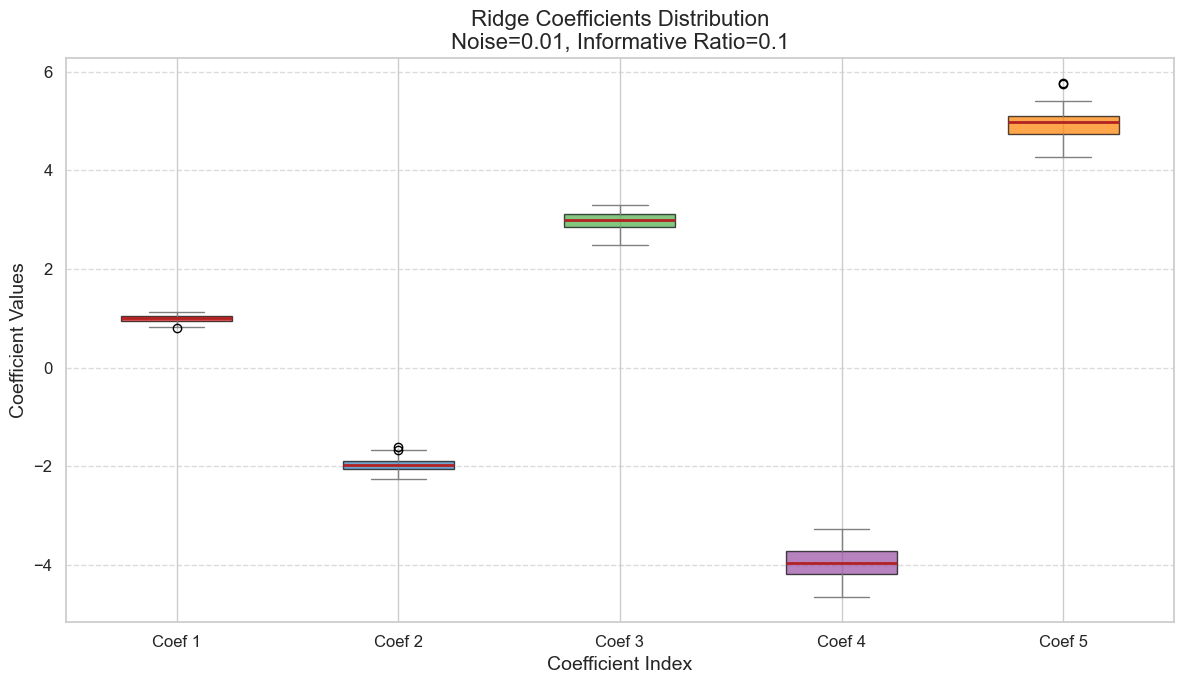

C:\Users\elsbr\AppData\Local\Temp\ipykernel_11356\3720518661.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


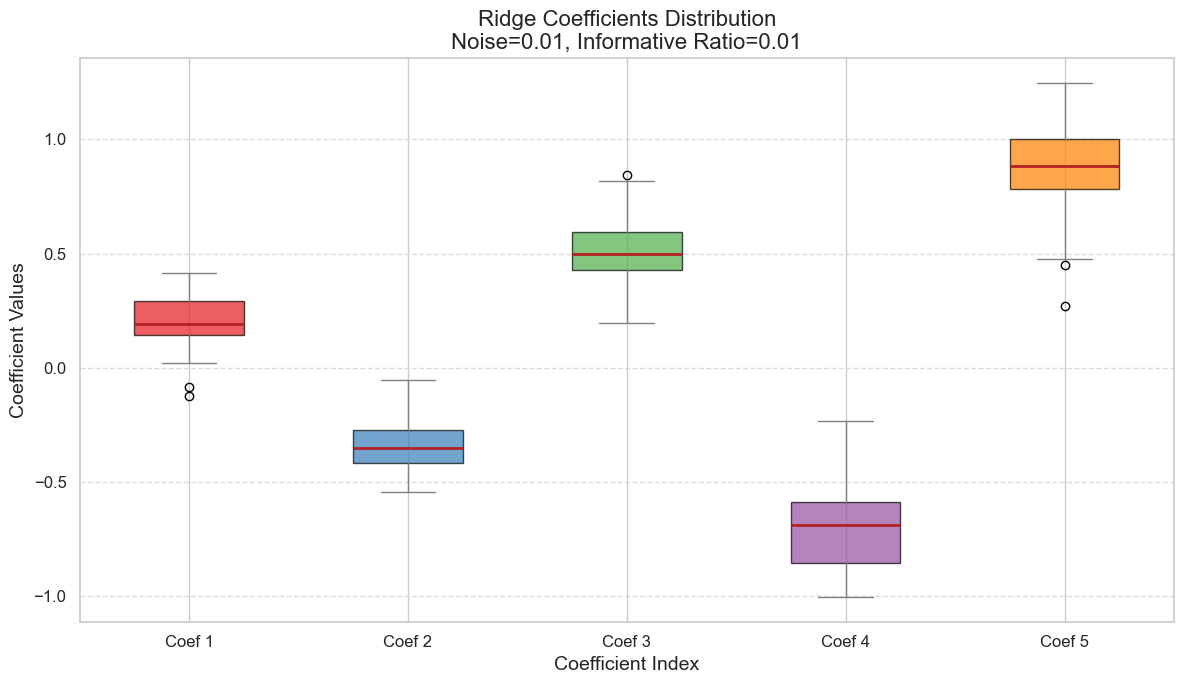

C:\Users\elsbr\AppData\Local\Temp\ipykernel_11356\3720518661.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


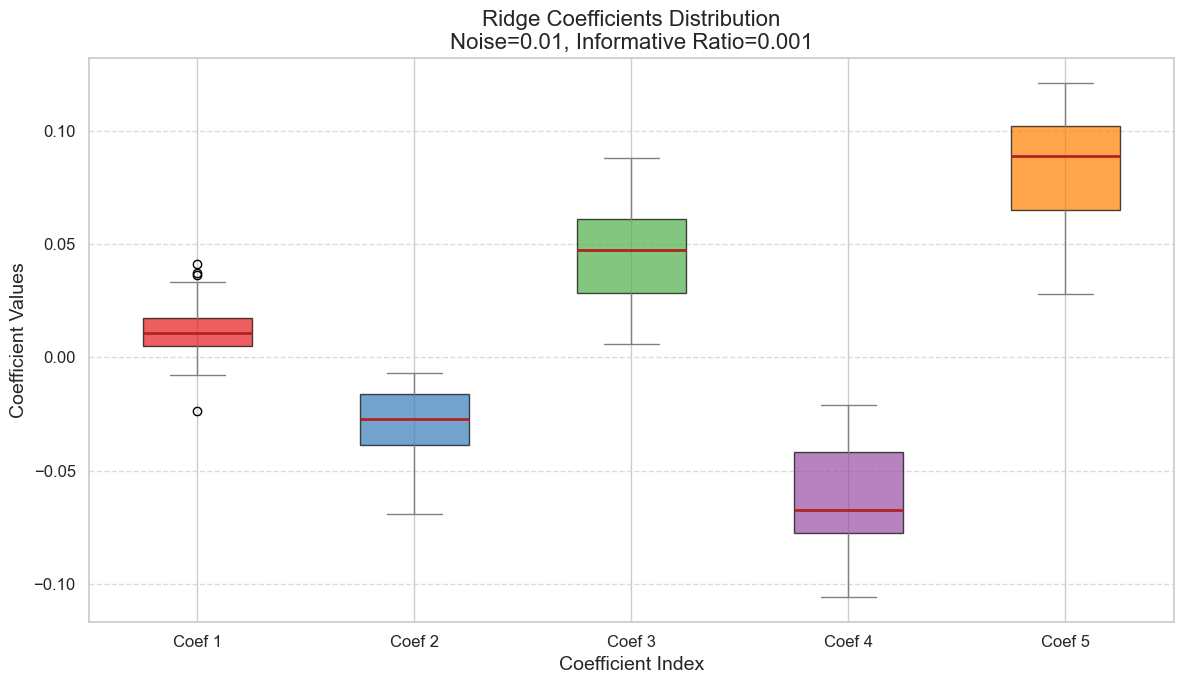

In [22]:
# Use seaborn style and Set2 palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set1", 5)  # 5 distinct colors from Set2

# Filter for noise == 0.01
df_filtered = df_Ridge_simulations[df_Ridge_simulations['noise'] == 0.01].copy()

# Convert stringified lists to actual lists
df_filtered['model_coef'] = df_filtered['model_coef'].apply(ast.literal_eval)

ir_list = [0.1, 0.01, 0.001]

for ir in ir_list:
    df_ir = df_filtered[df_filtered['ir'] == ir]

    # Extract first 5 coefficients from each list
    coeffs = {i: [] for i in range(5)}
    for coef_list in df_ir['model_coef']:
        for i in range(5):
            coeffs[i].append(coef_list[i])

    # Prepare data for boxplot
    data_to_plot = [coeffs[i] for i in range(5)]

    plt.figure(figsize=(12, 7))
    box = plt.boxplot(
        data_to_plot,
        labels=[f'Coef {i+1}' for i in range(5)],
        patch_artist=True,
        medianprops=dict(color='firebrick', linewidth=2),
        whiskerprops=dict(color='gray'),
        capprops=dict(color='gray')
    )

    # Apply Set2 colors to each box
    for patch, color in zip(box['boxes'], palette):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    plt.title(f'Ridge Coefficients Distribution\nNoise=0.01, Informative Ratio={ir}', fontsize=16)
    plt.ylabel('Coefficient Values', fontsize=14)
    plt.xlabel('Coefficient Index', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

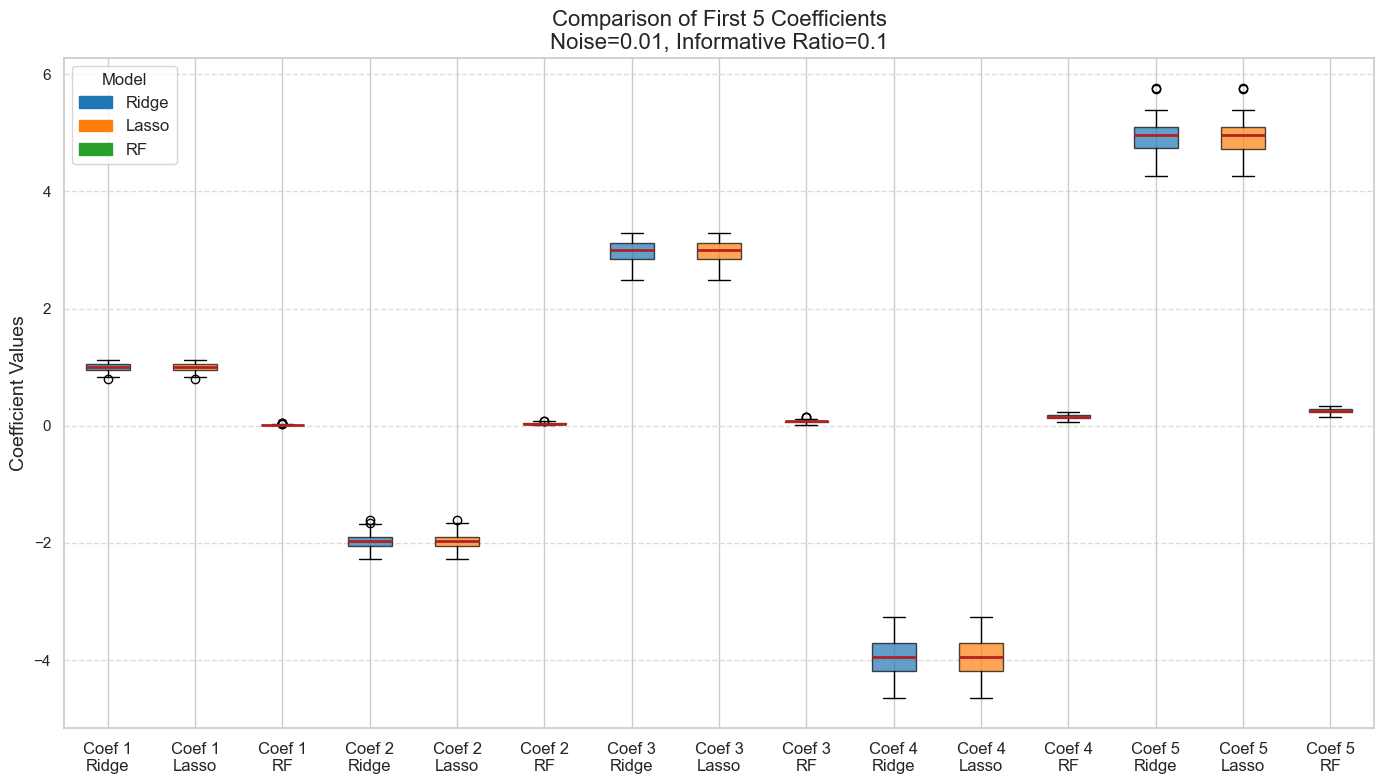

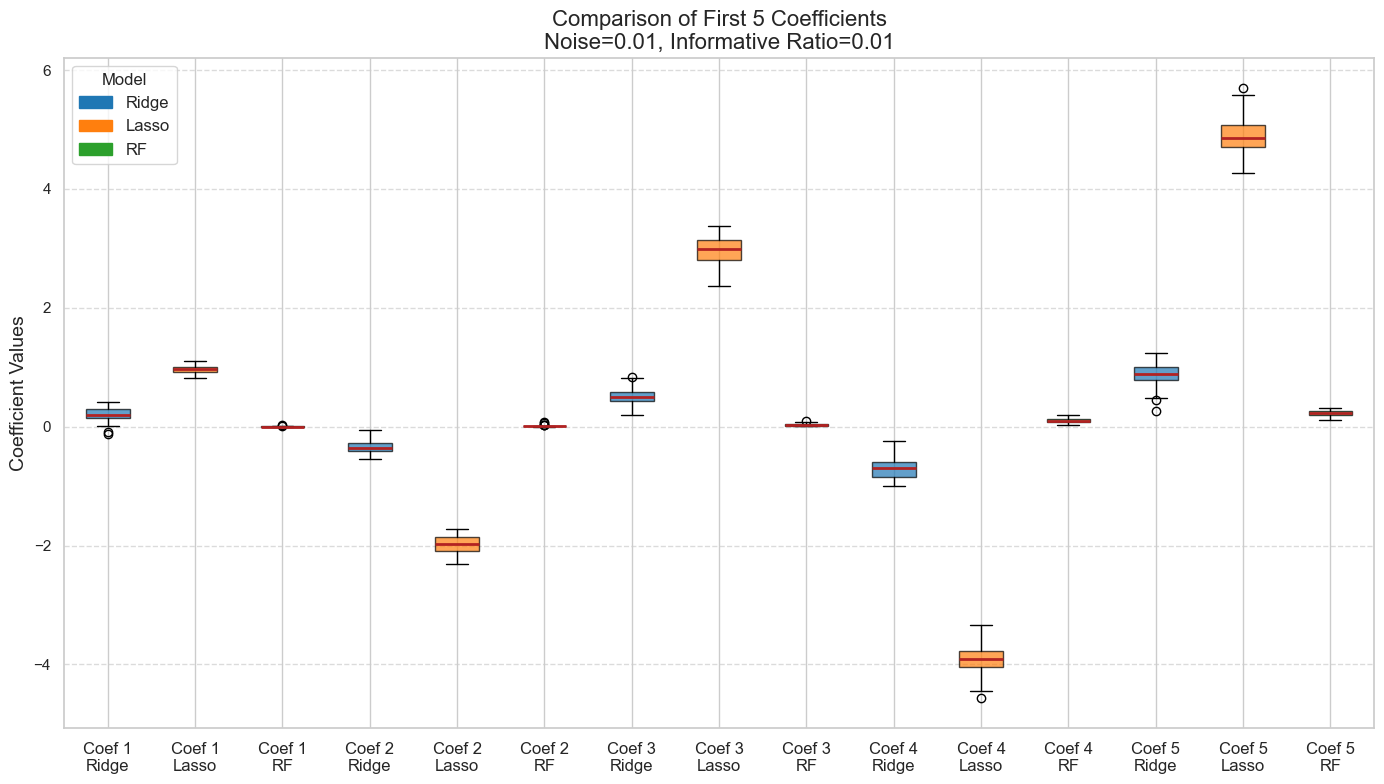

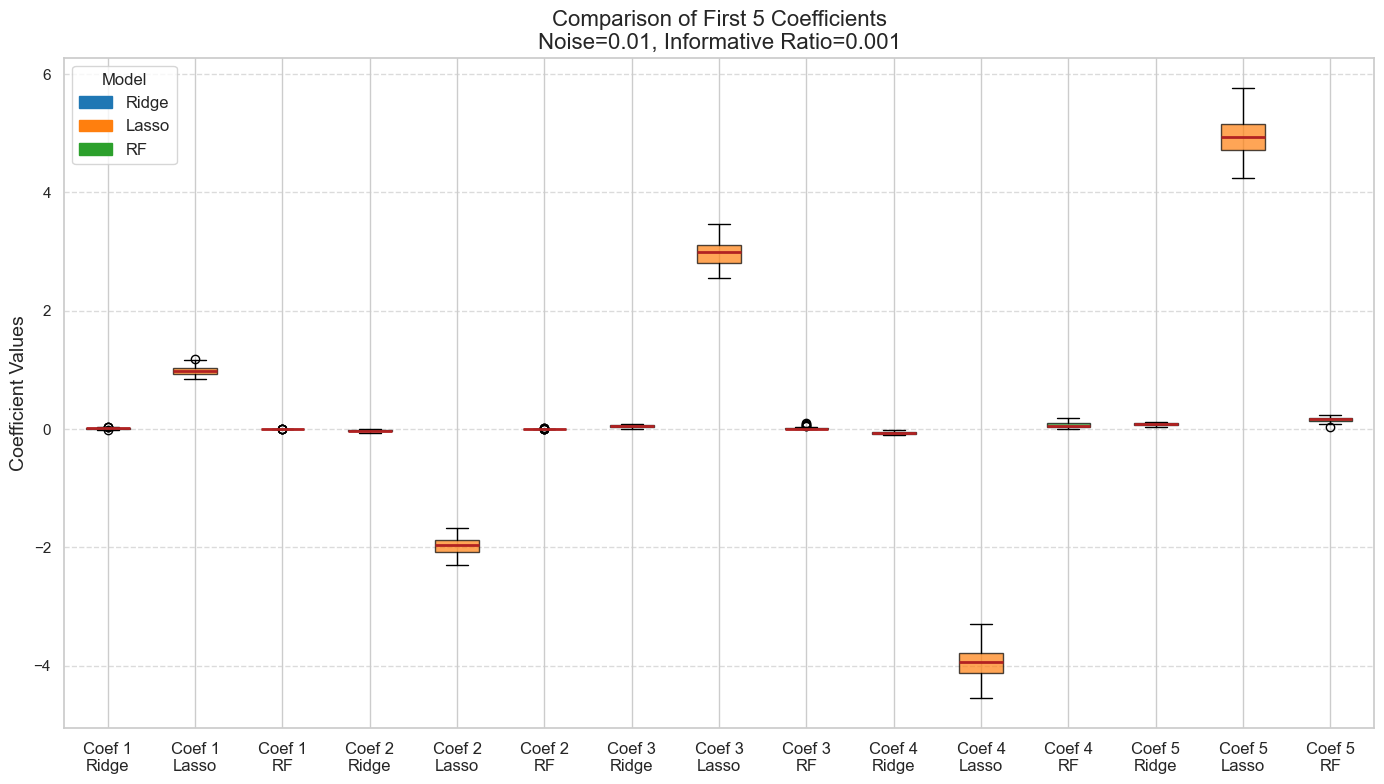

In [23]:
sns.set(style="whitegrid")

# Define colors for models
model_colors = {'Ridge': 'tab:blue', 'Lasso': 'tab:orange', 'RF': 'tab:green'}

# Load and filter data for noise=0.01
def prepare_data(df):
    df_filtered = df[df['noise'] == 0.01].copy()
    df_filtered['model_coef'] = df_filtered['model_coef'].apply(ast.literal_eval)
    return df_filtered

def prepare_data_RF(df):
    df_filtered = df[df['noise'] == 0.01].copy()
    df_filtered['model_importance'] = df_filtered['model_importance'].apply(ast.literal_eval)
    return df_filtered

df_ridge = prepare_data(df_Ridge_simulations)
df_lasso = prepare_data(df_Lasso_simulations)
df_rf = prepare_data_RF(df_RF_simulations)

ir_list = [0.1, 0.01, 0.001]

for ir in ir_list:
    # Filter each dataframe by ir
    ridge_ir = df_ridge[df_ridge['ir'] == ir]
    lasso_ir = df_lasso[df_lasso['ir'] == ir]
    rf_ir = df_rf[df_rf['ir'] == ir]
    
    # Extract first 5 coefficients for each model
    def extract_coefs(df):
        coeffs = {i: [] for i in range(5)}
        for coefs_list in df['model_coef']:
            for i in range(5):
                coeffs[i].append(coefs_list[i])
        return coeffs
    
        # Extract first 5 coefficients for each model
    def extract_coefs_RF(df):
        coeffs = {i: [] for i in range(5)}
        for coefs_list in df['model_importance']:
            for i in range(5):
                coeffs[i].append(coefs_list[i])
        return coeffs

    ridge_coefs = extract_coefs(ridge_ir)
    lasso_coefs = extract_coefs(lasso_ir)
    rf_coefs = extract_coefs_RF(rf_ir)

    # Organize data for grouped boxplot
    # For each coefficient index, we want 3 datasets (ridge, lasso, rf)
    data = []
    labels = []
    for i in range(5):
        data.append(ridge_coefs[i])
        data.append(lasso_coefs[i])
        data.append(rf_coefs[i])
        labels.extend([f'Coef {i+1}\nRidge', f'Coef {i+1}\nLasso', f'Coef {i+1}\nRF'])

    # Plot
    plt.figure(figsize=(14, 8))
    box = plt.boxplot(data, patch_artist=True)

    # Set colors per model within each group of 3 boxes
    for i, patch in enumerate(box['boxes']):
        # Determine model by box index mod 3
        model_idx = i % 3
        if model_idx == 0:
            patch.set_facecolor(model_colors['Ridge'])
        elif model_idx == 1:
            patch.set_facecolor(model_colors['Lasso'])
        else:
            patch.set_facecolor(model_colors['RF'])
        patch.set_alpha(0.7)

    # Set median line color
    for median in box['medians']:
        median.set(color='firebrick', linewidth=2)

    plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, fontsize=12)
    plt.ylabel('Coefficient Values', fontsize=14)
    plt.title(f'Comparison of First 5 Coefficients\nNoise=0.01, Informative Ratio={ir}', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend manually
    from matplotlib.patches import Patch
    legend_handles = [Patch(color=color, label=model) for model, color in model_colors.items()]
    plt.legend(handles=legend_handles, title='Model', fontsize=12)

    plt.tight_layout()
    plt.show()

In [27]:
# Set seaborn style
sns.set(style="whitegrid")

# Define colors for each model
model_colors = {'Ridge': 'tab:blue', 'Lasso': 'tab:orange', 'RF': 'tab:green'}

# Create directory for saving figures
os.makedirs("figures theta nonuniform", exist_ok=True)

# Prepare data by parsing stringified lists into actual lists
def prepare_data(df, column='model_coef'):
    df_filtered = df[df['noise'] == 0.01].copy()
    df_filtered[column] = df_filtered[column].apply(ast.literal_eval)
    return df_filtered

# Prepare all model datasets
df_ridge = prepare_data(df_Ridge_simulations, 'model_coef')
df_lasso = prepare_data(df_Lasso_simulations, 'model_coef')
df_rf = prepare_data(df_RF_simulations, 'model_importance')

# List of informative ratios to plot
ir_list = [0.1, 0.01, 0.001]

# Loop through each IR and create a plot
for ir in ir_list:
    ridge_ir = df_ridge[df_ridge['ir'] == ir]
    lasso_ir = df_lasso[df_lasso['ir'] == ir]
    rf_ir = df_rf[df_rf['ir'] == ir]

    # Function to normalize coefficients and extract only the first 5
    def extract_normalized(df, col_name):
        coeffs = {i: [] for i in range(5)}
        for coefs_list in df[col_name]:
            abs_vals = np.abs(coefs_list)
            norm = abs_vals / np.sum(abs_vals)
            for i in range(5):
                coeffs[i].append(norm[i])
        return coeffs

    # Extract normalized coefficients/importances
    ridge_coefs = extract_normalized(ridge_ir, 'model_coef')
    lasso_coefs = extract_normalized(lasso_ir, 'model_coef')
    rf_coefs = extract_normalized(rf_ir, 'model_importance')

    # Combine data for grouped boxplots
    data = []
    labels = []
    for i in range(5):
        data.append(ridge_coefs[i])
        data.append(lasso_coefs[i])
        data.append(rf_coefs[i])
        labels.extend([f'Coef {i+1}\nRidge', f'Coef {i+1}\nLasso', f'Coef {i+1}\nRF'])

    # Plotting
    plt.figure(figsize=(14, 8))
    box = plt.boxplot(data, patch_artist=True)

    # Set box colors
    for i, patch in enumerate(box['boxes']):
        model_idx = i % 3
        if model_idx == 0:
            patch.set_facecolor(model_colors['Ridge'])
        elif model_idx == 1:
            patch.set_facecolor(model_colors['Lasso'])
        else:
            patch.set_facecolor(model_colors['RF'])
        patch.set_alpha(0.7)

    # Set median line style
    for median in box['medians']:
        median.set(color='firebrick', linewidth=2)

    # Axis settings
    plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, fontsize=12)
    plt.ylabel('Normalized Coefficient Magnitude', fontsize=14)
    plt.title(f'Relative Importance of Informative Coefficients\nNoise=0.01, Informative Ratio={ir}', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend
    legend_handles = [Patch(color=color, label=model) for model, color in model_colors.items()]
    plt.legend(handles=legend_handles, title='Model', fontsize=12)

    plt.tight_layout()

    # Save the figure
    filename = f"figures theta nonuniform/relative_importance_noise0.01_ir{ir}.png"
    plt.savefig(filename, dpi=300)
    plt.close()

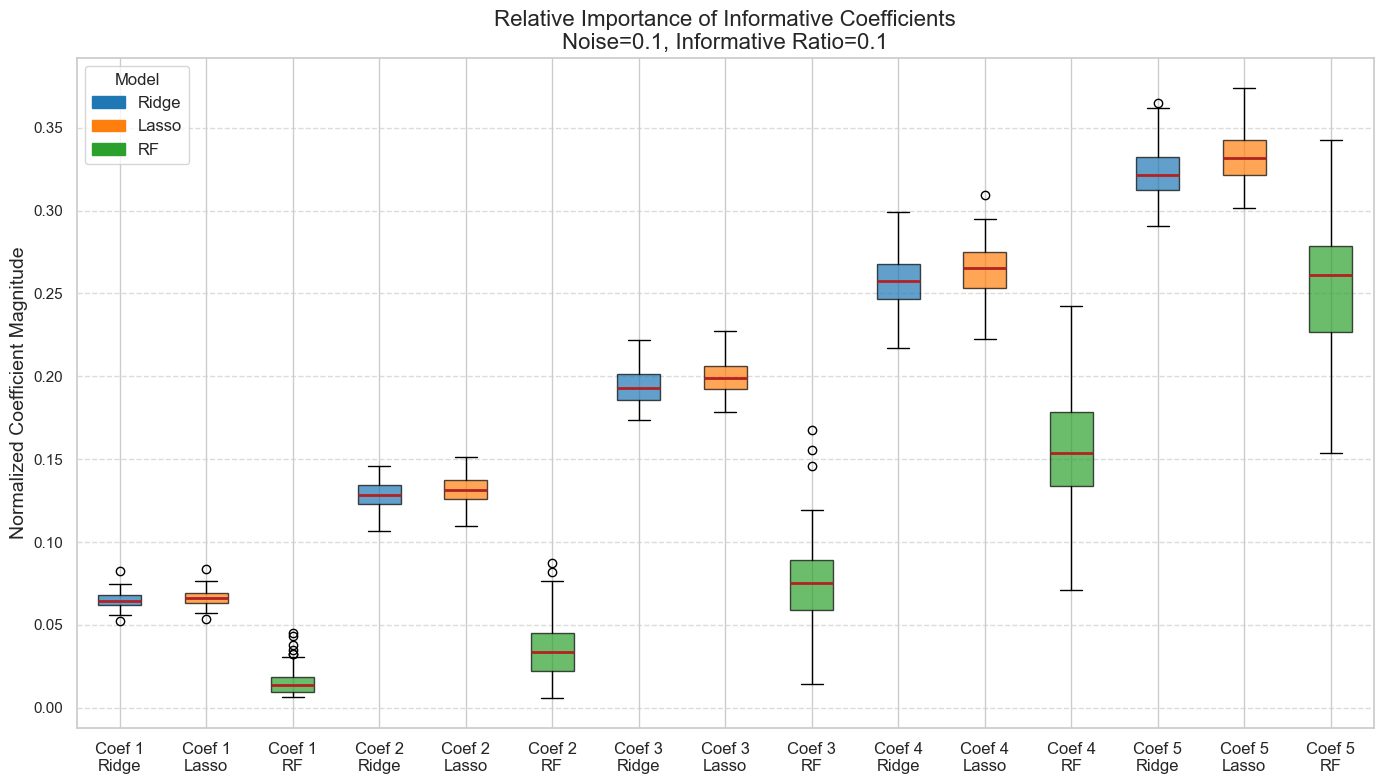

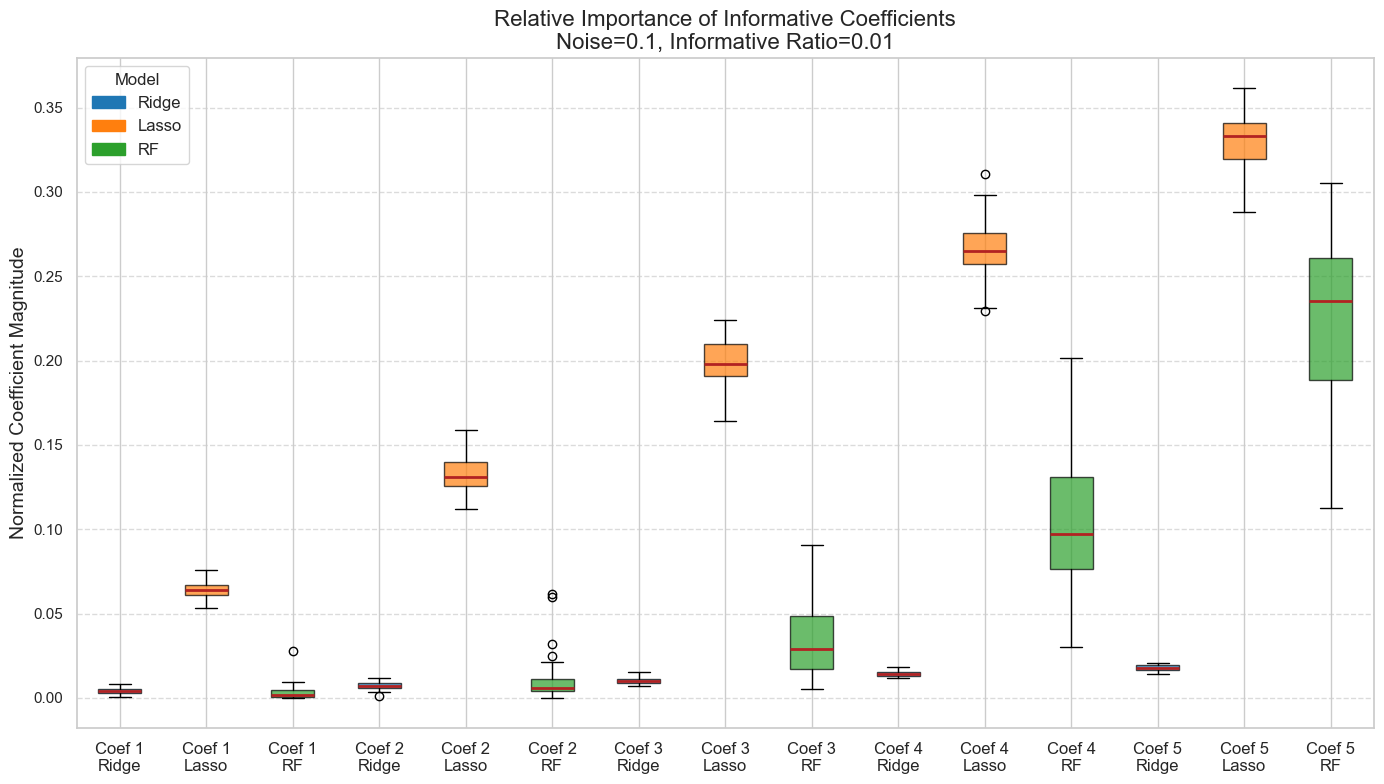

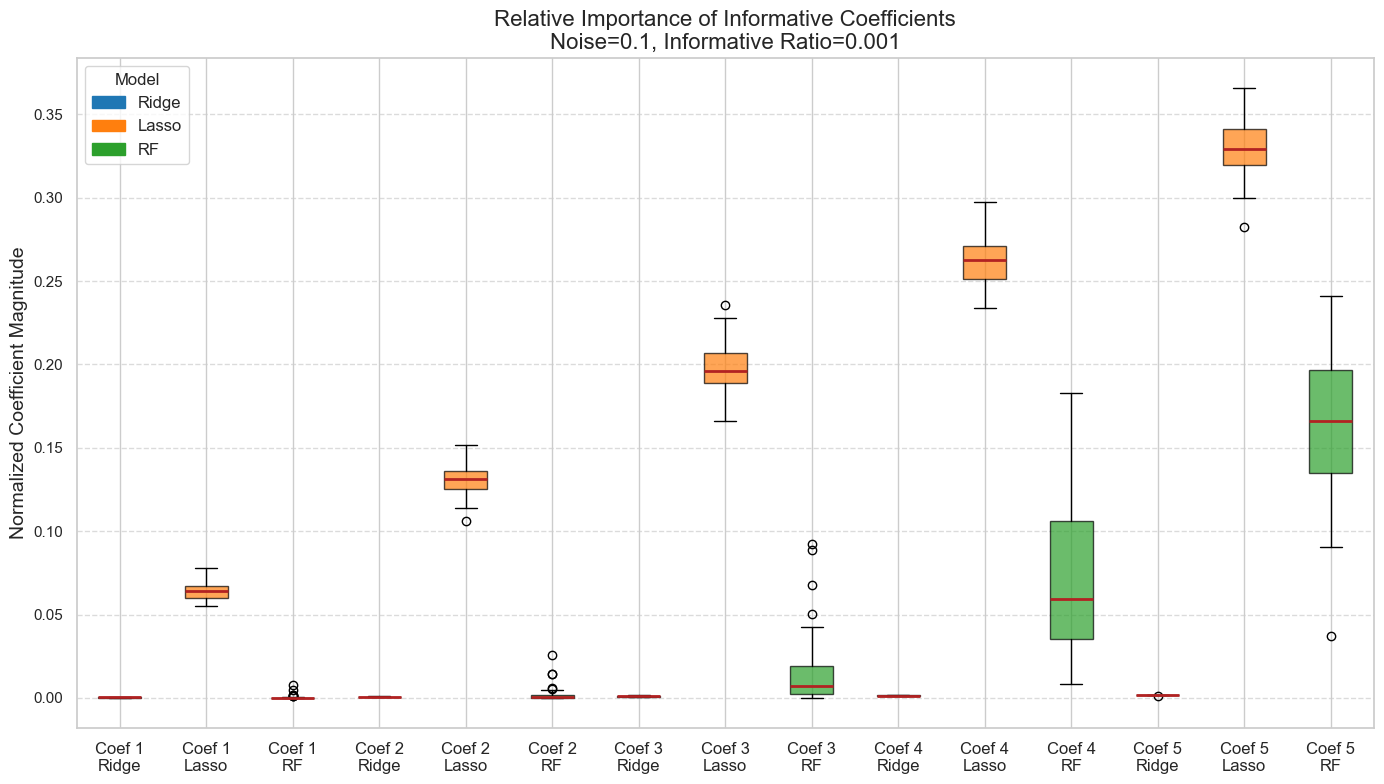

In [ ]:
sns.set(style="whitegrid")

model_colors = {'Ridge': 'tab:blue', 'Lasso': 'tab:orange', 'RF': 'tab:green'}

def prepare_data(df, column='model_coef'):
    df_filtered = df[df['noise'] == 0.1].copy()
    df_filtered[column] = df_filtered[column].apply(ast.literal_eval)
    return df_filtered

df_ridge = prepare_data(df_Ridge_simulations, 'model_coef')
df_lasso = prepare_data(df_Lasso_simulations, 'model_coef')
df_rf = prepare_data(df_RF_simulations, 'model_importance')

ir_list = [0.1, 0.01, 0.001]

for ir in ir_list:
    ridge_ir = df_ridge[df_ridge['ir'] == ir]
    lasso_ir = df_lasso[df_lasso['ir'] == ir]
    rf_ir = df_rf[df_rf['ir'] == ir]

    def extract_normalized(df, col_name):
        coeffs = {i: [] for i in range(5)}
        for coefs_list in df[col_name]:
            abs_vals = np.abs(coefs_list)
            norm = abs_vals / (np.sum(abs_vals))  
            for i in range(5):
                coeffs[i].append(norm[i])
        return coeffs

    ridge_coefs = extract_normalized(ridge_ir, 'model_coef')
    lasso_coefs = extract_normalized(lasso_ir, 'model_coef')
    rf_coefs = extract_normalized(rf_ir, 'model_importance')

    # Combine data for grouped boxplots
    data = []
    labels = []
    for i in range(5):
        data.append(ridge_coefs[i])
        data.append(lasso_coefs[i])
        data.append(rf_coefs[i])
        labels.extend([f'Coef {i+1}\nRidge', f'Coef {i+1}\nLasso', f'Coef {i+1}\nRF'])

    # Plotting
    plt.figure(figsize=(14, 8))
    box = plt.boxplot(data, patch_artist=True)

    for i, patch in enumerate(box['boxes']):
        model_idx = i % 3
        if model_idx == 0:
            patch.set_facecolor(model_colors['Ridge'])
        elif model_idx == 1:
            patch.set_facecolor(model_colors['Lasso'])
        else:
            patch.set_facecolor(model_colors['RF'])
        patch.set_alpha(0.7)

    for median in box['medians']:
        median.set(color='firebrick', linewidth=2)

    plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, fontsize=12)
    plt.ylabel('Normalized Coefficient Magnitude', fontsize=14)
    plt.title(f'Relative Importance of Informative Coefficients\nNoise=0.1, Informative Ratio={ir}', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    legend_handles = [Patch(color=color, label=model) for model, color in model_colors.items()]
    plt.legend(handles=legend_handles, title='Model', fontsize=12)

    plt.tight_layout()
    plt.show()
